# Importing Libraries

In [2]:
# importing all the necessary libraries

import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
from sklearn.metrics import classification_report #for detailed statistics on classifier
from sklearn.metrics import confusion_matrix
from torchvision.datasets import MNIST  #importing MNIST dataset
from tqdm import tqdm
from torchvision import transforms #for transforming the training and testing data 
from torch.utils.data import DataLoader #Dataloader loads the data batchwise with shuffling in a hassle free manner
from torch.optim import Adam #Adam for GD
import time # to see how long training took

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))

Using device: cuda
Tesla T4


# Dataset

In [9]:
bs= 500 # batch_size
app_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

#organize the training and test data

train_data    = MNIST('', train = True, download = True, transform = app_transform) #getting training data
test_data     = MNIST('', train = False, transform = app_transform)
train_data,val_data=torch.utils.data.random_split(train_data,(50000,10000))

#initialize the dataloaders
TrainDataLoader = DataLoader(train_data, batch_size = bs, shuffle = True ) 
TestDataLoader  = DataLoader(test_data, batch_size = bs) 
ValDataLoader   = DataLoader(val_data, batch_size = bs) 

train_length  = len(TrainDataLoader.dataset) 
val_length    = len(ValDataLoader.dataset)
test_length   = len(TestDataLoader.dataset) 

print ('Train Length:', train_length) 
print ('Test Length:', test_length) 
print ('Validation  Length:', val_length) 



Train Length: 50000
Test Length: 10000
Validation  Length: 10000


# <h1><center><font color = Green >1.MNIST using RNN</center></h1>


# RNN

In [4]:
class Vanilla_RNN(nn.Module):
    
    def __init__(self):
        super(Vanilla_RNN, self).__init__()
        
        self.rnn = nn.RNN(input_size = 28, 
                          hidden_size = 128, 
                          num_layers = 1,
                          bidirectional = False, 
                          batch_first = True)
        
        self.HL = nn.Linear(128 ,10) 
        
        self.logsoftmax = nn.LogSoftmax(dim = 1)
    
    def forward(self,x):
        states,hidden_ = self.rnn(x)
        out = self.HL(states[:,-1,:])
        pred   = self.logsoftmax(out)
        
        return pred

In [10]:
l_rate = 0.002
epochs = 10
regul=0.01
loss_fn = nn.CrossEntropyLoss()

In [30]:
from tqdm.notebook import tqdm
train_loss = []
train_correct = []
val_loss = []
val_accuracy = []

model1=Vanilla_RNN()
optimizer1 = torch.optim.Adam(model1.parameters(), lr=l_rate)

for epoch in range(10):
  for  (data, labels) in tqdm(TrainDataLoader):
    data = data.view(-1, 28, 28) 
    outputs = model1(data)
    loss = loss_fn(outputs, labels)
    train_loss.append(loss.item())
    
    optimizer1.zero_grad()
    loss.backward()
    optimizer1.step()
    #train_loss    += loss
    _,predicted=torch.max(outputs.data, 1)
    #train_correct += (predicted == labels).sum().item()     
    #train_correct += (pred == labels).sum().item()

    
  iter=0
  tempvalloss=0
  correctval=0    
  
  for data, labels in tqdm(ValDataLoader):
    data = data.view(-1, 28, 28) 
    outputs = model1(data)
    loss = loss_fn(outputs, labels)
    _, predicted = torch.max(outputs.data, 1)
    correctval += (predicted == labels).sum().item()
    iter+=1
    tempvalloss+=loss.item()
      
  val_loss.append(tempvalloss/iter)
  val_accuracy.append(correctval/100)
  print('Epoch',epoch+1,'out of',epochs,'epochs are over')

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1 out of 10 epochs are over


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2 out of 10 epochs are over


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3 out of 10 epochs are over


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4 out of 10 epochs are over


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 5 out of 10 epochs are over


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 6 out of 10 epochs are over


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 7 out of 10 epochs are over


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 8 out of 10 epochs are over


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 9 out of 10 epochs are over


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 10 out of 10 epochs are over


##### The exact same above has to be done with regularization on a new set of models

In [36]:
from tqdm.notebook import tqdm
train_loss_r = []
train_correct_r = []
val_loss_r = []
val_accuracy_r = []

model1r=Vanilla_RNN()
optimizer1r = torch.optim.Adam(model1r.parameters(), lr=l_rate)

for epoch in range(10):
  for  (data, labels) in tqdm(TrainDataLoader):
    data = data.view(-1, 28, 28) 
    outputs = model1r(data)
    loss_r = loss_fn(outputs, labels) + regul*torch.norm(model1r.HL.weight)
    train_loss_r.append(loss_r.item())
    
    optimizer1r.zero_grad()
    loss_r.backward()
    optimizer1r.step()
    #train_loss    += loss
    _,predicted_r=torch.max(outputs.data, 1)
    #train_correct += (predicted == labels).sum().item()     
    #train_correct += (pred == labels).sum().item()

    
  iter_r=0
  tempvalloss_r=0
  correctval_r=0    
  
  for data, labels in tqdm(ValDataLoader):
    data = data.view(-1, 28, 28) 
    outputs = model1r(data)
    loss_r = loss_fn(outputs, labels)
    _, predicted = torch.max(outputs.data, 1)
    correctval_r += (predicted == labels).sum().item()
    iter_r+=1
    tempvalloss_r+=loss_r.item()
      
  val_loss_r.append(tempvalloss_r/iter_r)
  val_accuracy_r.append(correctval_r/100)
  print('Epoch',epoch+1,'out of',epochs,'epochs are over')

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1 out of 10 epochs are over


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2 out of 10 epochs are over


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3 out of 10 epochs are over


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4 out of 10 epochs are over


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 5 out of 10 epochs are over


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 6 out of 10 epochs are over


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 7 out of 10 epochs are over


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 8 out of 10 epochs are over


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 9 out of 10 epochs are over


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 10 out of 10 epochs are over


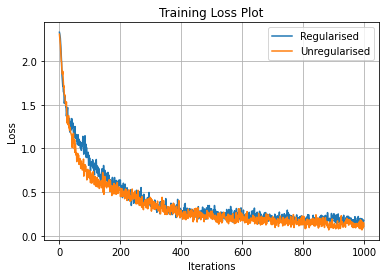

In [31]:
num_iters = len(train_loss)

plt.figure()
plt.plot(np.arange(num_iters), train_loss_r, label='Regularised')
plt.plot(np.arange(num_iters), train_loss, label='Unregularised')
plt.grid()
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training Loss Plot')
plt.show()

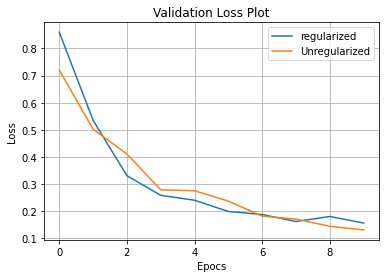

In [35]:
num_iters = len(train_loss)

plt.figure()
iter = len(val_loss)
plt.plot(np.arange(iter),val_loss_r,label="regularized")
plt.plot(np.arange(iter),val_loss,label="Unregularized")
plt.grid()
plt.xlabel('Epocs')
plt.ylabel('Loss')
plt.legend()
plt.title('Validation Loss Plot')
plt.show()


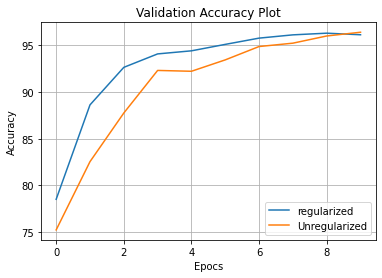

In [37]:
plt.figure()
plt.plot(np.arange(iter),val_accuracy_r,label="regularized")
plt.plot(np.arange(iter),val_accuracy,label="Unregularized")
plt.grid()
plt.xlabel('Epocs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy Plot')
plt.show()


In [40]:
model1.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for data, labels in tqdm(TestDataLoader):
      data = data.reshape(-1, 28, 28) 
      outputs = model1(data)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

    print('Test Accuracy of the unregularized model: {} %'.format((correct / total) * 100))

model1r.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for data, labels in tqdm(TestDataLoader):
      data = data.reshape(-1, 28, 28) 
      outputs = model1r(data)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

    print('Test Accuracy of the regularized model: {} %'.format((correct / total) * 100))    

  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy of the unregularized model: 96.26 %


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy of the regularized model: 96.57 %


<function matplotlib.pyplot.show(*args, **kw)>

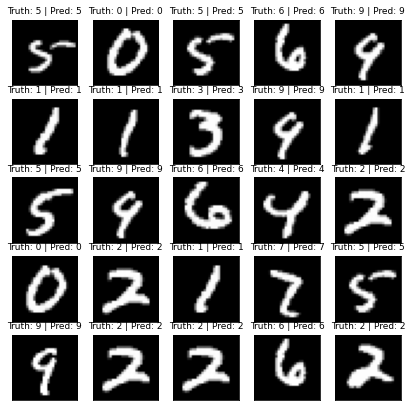

In [92]:
ix =1
a=(25*np.abs(np.random.rand(25))).astype(int)
predict=np.zeros(25)
actual=np.zeros(25)
fig,ax = plt.subplots()
fig.set_figheight(7)
fig.set_figwidth(7)
cols,rows=5,5
for i in range(0,cols*rows):
  ax=plt.subplot(5,5,ix)
  ax.set_xticks([])
  ax.set_yticks([])
  im=ax.imshow(data[a[i]],cmap='gray')
  _,predicted=torch.max(model1r(data)[a[i]],0)
  plt.title('Truth: {} | Pred: {}'.format(predicted.item(),labels[a[i]]), fontsize=9)
  ix+=1
plt.show

# LSTM

In [60]:
class Vanilla_LSTM(nn.Module):
    
    def __init__(self): 
        super(Vanilla_LSTM, self).__init__() 
        
        self.lstm = nn.LSTM(input_size = 28, 
                          hidden_size = 128, 
                          num_layers = 1,
                          bidirectional = True, 
                          batch_first = True)
        
        
        self.HL = nn.Linear(2*128,10) 
        
        self.logsoftmax = nn.LogSoftmax(dim = 1)
              
    
    def forward(self,x): 
                
        h_0 = torch.zeros(2, x.size(0), 128).requires_grad_()

        c_0 = torch.zeros(2, x.size(0), 128).requires_grad_()

        out, (h_n, c_n) = self.lstm(x, (h_0.detach(), c_0.detach()))

        out = self.HL(out[:,-1,:]) 

        pred   = self.logsoftmax(out)
        
        return pred

In [61]:
l_rate = 0.002
epochs = 10
regul=0.004
loss_fn = nn.CrossEntropyLoss()

In [62]:
from tqdm.notebook import tqdm
train_loss = []
train_correct = []
val_loss = []
val_accuracy = []

model2=Vanilla_LSTM()
optimizer2 = torch.optim.Adam(model2.parameters(), lr=l_rate)

for epoch in range(10):
  for  (data, labels) in tqdm(TrainDataLoader):
    data = data.view(-1, 28, 28) 
    outputs = model2(data)
    loss = loss_fn(outputs, labels)
    train_loss.append(loss.item())
    
    optimizer2.zero_grad()
    loss.backward()
    optimizer2.step()
    #train_loss    += loss
    _,predicted=torch.max(outputs.data, 1)
    #train_correct += (predicted == labels).sum().item()     
    #train_correct += (pred == labels).sum().item()

    
  iter=0
  tempvalloss=0
  correctval=0    
  
  for data, labels in tqdm(ValDataLoader):
    data = data.view(-1, 28, 28) 
    outputs = model2(data)
    loss = loss_fn(outputs, labels)
    _, predicted = torch.max(outputs.data, 1)
    correctval += (predicted == labels).sum().item()
    iter+=1
    tempvalloss+=loss.item()
      
  val_loss.append(tempvalloss/iter)
  val_accuracy.append(correctval/100)
  print('Epoch',epoch+1,'out of',epochs,'epochs are over')

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1 out of 10 epochs are over


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2 out of 10 epochs are over


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3 out of 10 epochs are over


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4 out of 10 epochs are over


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 5 out of 10 epochs are over


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 6 out of 10 epochs are over


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 7 out of 10 epochs are over


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 8 out of 10 epochs are over


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 9 out of 10 epochs are over


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 10 out of 10 epochs are over


Regularisation

In [63]:
from tqdm.notebook import tqdm
train_loss_r = []
train_correct_r = []
val_loss_r = []
val_accuracy_r = []

model2r=Vanilla_LSTM()
optimizer2r = torch.optim.Adam(model2r.parameters(), lr=l_rate)

for epoch in range(10):
  for  (data, labels) in tqdm(TrainDataLoader):
    data = data.view(-1, 28, 28) 
    outputs = model2r(data)
    loss_r = loss_fn(outputs, labels) + regul*torch.norm(model2r.HL.weight)
    train_loss_r.append(loss_r.item())
    
    optimizer2r.zero_grad()
    loss_r.backward()
    optimizer2r.step()
    #train_loss    += loss
    _,predicted_r=torch.max(outputs.data, 1)
    #train_correct += (predicted == labels).sum().item()     
    #train_correct += (pred == labels).sum().item()

    
  iter_r=0
  tempvalloss_r=0
  correctval_r=0    
  
  for data, labels in tqdm(ValDataLoader):
    data = data.view(-1, 28, 28) 
    outputs = model2r(data)
    loss_r = loss_fn(outputs, labels)
    _, predicted = torch.max(outputs.data, 1)
    correctval_r += (predicted == labels).sum().item()
    iter_r+=1
    tempvalloss_r+=loss_r.item()
      
  val_loss_r.append(tempvalloss_r/iter_r)
  val_accuracy_r.append(correctval_r/100)
  print('Epoch',epoch+1,'out of',epochs,'epochs are over')

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1 out of 10 epochs are over


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2 out of 10 epochs are over


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3 out of 10 epochs are over


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4 out of 10 epochs are over


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 5 out of 10 epochs are over


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 6 out of 10 epochs are over


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 7 out of 10 epochs are over


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 8 out of 10 epochs are over


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 9 out of 10 epochs are over


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 10 out of 10 epochs are over


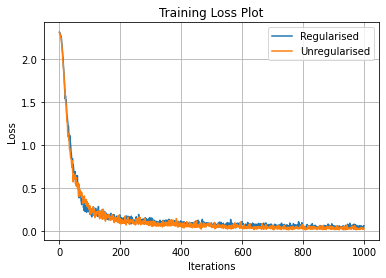

In [64]:
num_iters = len(train_loss)

plt.figure()
plt.plot(np.arange(num_iters), train_loss_r, label='Regularised')
plt.plot(np.arange(num_iters), train_loss, label='Unregularised')
plt.grid()
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training Loss Plot')
plt.show()

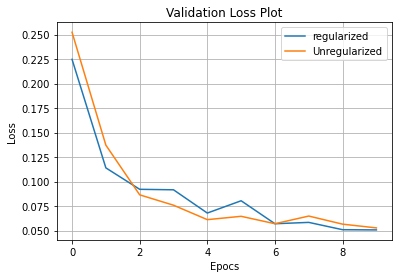

In [65]:
num_iters = len(train_loss)

plt.figure()
iter = len(val_loss)
plt.plot(np.arange(iter),val_loss_r,label="regularized")
plt.plot(np.arange(iter),val_loss,label="Unregularized")
plt.grid()
plt.xlabel('Epocs')
plt.ylabel('Loss')
plt.legend()
plt.title('Validation Loss Plot')
plt.show()


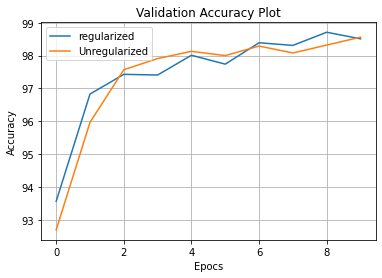

In [66]:
plt.figure()
plt.plot(np.arange(iter),val_accuracy_r,label="regularized")
plt.plot(np.arange(iter),val_accuracy,label="Unregularized")
plt.grid()
plt.xlabel('Epocs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy Plot')
plt.show()


In [67]:
model2.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for data, labels in tqdm(TestDataLoader):
      data = data.reshape(-1, 28, 28) 
      outputs = model2(data)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

    print('Test Accuracy of the unregularized model: {} %'.format((correct / total) * 100))

model2r.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for data, labels in tqdm(TestDataLoader):
      data = data.reshape(-1, 28, 28) 
      outputs = model2r(data)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

    print('Test Accuracy of the regularized model: {} %'.format((correct / total) * 100))    

  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy of the unregularized model: 98.36 %


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy of the regularized model: 98.5 %


<function matplotlib.pyplot.show(*args, **kw)>

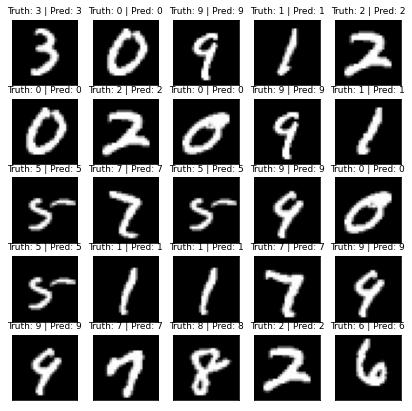

In [91]:
ix =1
a=(25*np.abs(np.random.rand(25))).astype(int)
predict=np.zeros(25)
actual=np.zeros(25)
fig,ax = plt.subplots()
fig.set_figheight(7)
fig.set_figwidth(7)
cols,rows=5,5
for i in range(0,cols*rows):
  ax=plt.subplot(5,5,ix)
  ax.set_xticks([])
  ax.set_yticks([])
  im=ax.imshow(data[a[i]],cmap='gray')
  _,predicted=torch.max(model2r(data)[a[i]],0)
  plt.title('Truth: {} | Pred: {}'.format(predicted.item(),labels[a[i]]), fontsize=9)
  ix+=1
plt.show

# GRU

In [53]:
class Vanilla_GRU(nn.Module):
    
    def __init__(self): 
        super(Vanilla_GRU, self).__init__() 
        
        self.gru = nn.GRU(input_size = 28, 
                          hidden_size = 128, 
                          num_layers = 1,
                          bidirectional = False, 
                          batch_first = True)
        
        self.HL = nn.Linear(128,10)
        
        self.logsoftmax = nn.LogSoftmax(dim = 1)
        
    
    def forward(self,x): 
        h_0 = torch.zeros(1 , x.size(0), 128).requires_grad_()
        out, h_n = self.gru(x, (h_0.detach()))
        out = self.HL(out[:,-1,:]) 

        pred   = self.logsoftmax(out)
        
        return pred

In [51]:
l_rate = 0.002
epochs = 10
regul=0.001
loss_fn = nn.CrossEntropyLoss()

In [54]:
from tqdm.notebook import tqdm
train_loss = []
train_correct = []
val_loss = []
val_accuracy = []

model3=Vanilla_GRU()
optimizer3 = torch.optim.Adam(model3.parameters(), lr=l_rate)

for epoch in range(10):
  for  (data, labels) in tqdm(TrainDataLoader):
    data = data.view(-1, 28, 28) 
    outputs = model3(data)
    loss = loss_fn(outputs, labels)
    train_loss.append(loss.item())
    
    optimizer3.zero_grad()
    loss.backward()
    optimizer3.step()
    #train_loss    += loss
    _,predicted=torch.max(outputs.data, 1)
    #train_correct += (predicted == labels).sum().item()     
    #train_correct += (pred == labels).sum().item()

    
  iter=0
  tempvalloss=0
  correctval=0    
  
  for data, labels in tqdm(ValDataLoader):
    data = data.view(-1, 28, 28) 
    outputs = model3(data)
    loss = loss_fn(outputs, labels)
    _, predicted = torch.max(outputs.data, 1)
    correctval += (predicted == labels).sum().item()
    iter+=1
    tempvalloss+=loss.item()
      
  val_loss.append(tempvalloss/iter)
  val_accuracy.append(correctval/100)
  print('Epoch',epoch+1,'out of',epochs,'epochs are over')

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1 out of 10 epochs are over


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2 out of 10 epochs are over


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3 out of 10 epochs are over


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4 out of 10 epochs are over


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 5 out of 10 epochs are over


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 6 out of 10 epochs are over


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 7 out of 10 epochs are over


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 8 out of 10 epochs are over


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 9 out of 10 epochs are over


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 10 out of 10 epochs are over


Regularisation

In [56]:
from tqdm.notebook import tqdm
train_loss_r = []
train_correct_r = []
val_loss_r = []
val_accuracy_r = []

model3r=Vanilla_GRU()
optimizer3r = torch.optim.Adam(model3r.parameters(), lr=l_rate)

for epoch in range(10):
  for  (data, labels) in tqdm(TrainDataLoader):
    data = data.view(-1, 28, 28) 
    outputs = model3r(data)
    loss_r = loss_fn(outputs, labels) + regul*torch.norm(model3r.HL.weight)
    train_loss_r.append(loss_r.item())
    
    optimizer3r.zero_grad()
    loss_r.backward()
    optimizer3r.step()
    #train_loss    += loss
    _,predicted_r=torch.max(outputs.data, 1)
    #train_correct += (predicted == labels).sum().item()     
    #train_correct += (pred == labels).sum().item()

    
  iter_r=0
  tempvalloss_r=0
  correctval_r=0    
  
  for data, labels in tqdm(ValDataLoader):
    data = data.view(-1, 28, 28) 
    outputs = model3r(data)
    loss_r = loss_fn(outputs, labels)
    _, predicted = torch.max(outputs.data, 1)
    correctval_r += (predicted == labels).sum().item()
    iter_r+=1
    tempvalloss_r+=loss_r.item()
      
  val_loss_r.append(tempvalloss_r/iter_r)
  val_accuracy_r.append(correctval_r/100)
  print('Epoch',epoch+1,'out of',epochs,'epochs are over')

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1 out of 10 epochs are over


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2 out of 10 epochs are over


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3 out of 10 epochs are over


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4 out of 10 epochs are over


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 5 out of 10 epochs are over


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 6 out of 10 epochs are over


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 7 out of 10 epochs are over


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 8 out of 10 epochs are over


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 9 out of 10 epochs are over


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 10 out of 10 epochs are over


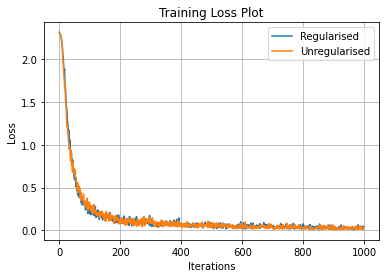

In [ ]:
num_iters = len(train_loss)

plt.figure()
plt.plot(np.arange(num_iters), train_loss_r, label='Regularised')
plt.plot(np.arange(num_iters), train_loss, label='Unregularised')
plt.grid()
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training Loss Plot')
plt.show()

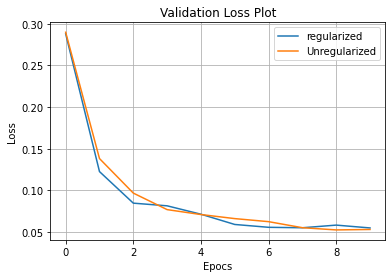

In [57]:
num_iters = len(train_loss)

plt.figure()
iter = len(val_loss)
plt.plot(np.arange(iter),val_loss_r,label="regularized")
plt.plot(np.arange(iter),val_loss,label="Unregularized")
plt.grid()
plt.xlabel('Epocs')
plt.ylabel('Loss')
plt.legend()
plt.title('Validation Loss Plot')
plt.show()


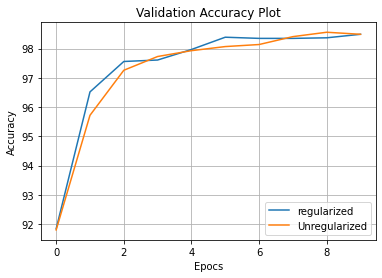

In [58]:
plt.figure()
plt.plot(np.arange(iter),val_accuracy_r,label="regularized")
plt.plot(np.arange(iter),val_accuracy,label="Unregularized")
plt.grid()
plt.xlabel('Epocs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy Plot')
plt.show()


In [59]:
model3.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for data, labels in tqdm(TestDataLoader):
      data = data.reshape(-1, 28, 28) 
      outputs = model3(data)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

    print('Test Accuracy of the unregularized model: {} %'.format((correct / total) * 100))

model3r.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for data, labels in tqdm(TestDataLoader):
      data = data.reshape(-1, 28, 28) 
      outputs = model3r(data)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

    print('Test Accuracy of the regularized model: {} %'.format((correct / total) * 100))    

  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy of the unregularized model: 98.34 %


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy of the regularized model: 98.52 %


<function matplotlib.pyplot.show(*args, **kw)>

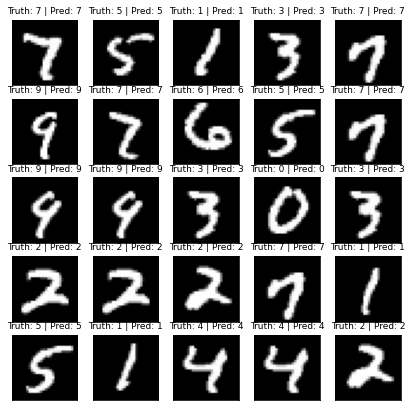

In [93]:
ix =1
a=(25*np.abs(np.random.rand(25))).astype(int)
predict=np.zeros(25)
actual=np.zeros(25)
fig,ax = plt.subplots()
fig.set_figheight(7)
fig.set_figwidth(7)
cols,rows=5,5
for i in range(0,cols*rows):
  ax=plt.subplot(5,5,ix)
  ax.set_xticks([])
  ax.set_yticks([])
  im=ax.imshow(data[a[i]],cmap='gray')
  _,predicted=torch.max(model3r(data)[a[i]],0)
  plt.title('Truth: {} | Pred: {}'.format(predicted.item(),labels[a[i]]), fontsize=9)
  ix+=1
plt.show

# <h1><center><font color = Green >2. Remembering the number at a particular index in a sequence</center></h1>

**Dataset Preparation**

In [139]:
elements_in_batch = 50
num_batches = 1000
position = 1
input_list = []
output_list = []
label_list = []

for i in range(num_batches):
    seqLength = np.random.randint(low=3, high=11)
    inptemp = torch.zeros(size=(elements_in_batch, seqLength, 10))
    outtemp = torch.zeros(size=(elements_in_batch, 10))
    labeltemp = torch.zeros(size=(elements_in_batch,))
    for j in range(elements_in_batch):
        for k in range(seqLength):
            temp = np.random.randint(low=0, high=10)
            inptemp[j,k,temp] = 1
            if k==position:
                outtemp[j,temp] = 1
                labeltemp[j] = temp
    
    input_list.append(inptemp)
    output_list.append(outtemp)
    label_list.append(labeltemp.type(torch.LongTensor))

# Splitting batches for training and testing
trainB = (4*num_batches)//5
train_data = list(zip(input_list[:trainB], output_list[:trainB], label_list[:trainB]))
test_data = list(zip(input_list[trainB:], output_list[trainB:], label_list[trainB:]))

loaders = {
    'train': train_data,
    'test': test_data
}

In [133]:
def train_loop_mod(loaders, model, loss_fn, optimizer, interval=75):
   
    dataloader = loaders['train']
    size = len(dataloader)*len(dataloader[0][2])
    losses = []
    losses_test = []
    acc_test = []


    for batch, iter in enumerate(dataloader):
        # Unpacking
        X, y, labels = iter
        
        # Compute prediction and loss
        temp = model(X)
        loss = loss_fn(input=temp['out'], target=labels)
        losses.append(loss.item())

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % interval == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"Loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            temp1 = test_loop_mod(loaders, model, loss_fn)
            losses_test.append(temp1['loss'])
            acc_test.append(temp1['acc'])
        
    return {
        'losses': losses,
        'losses_test': losses_test,
        'acc_test': acc_test
    }


In [134]:
def test_loop_mod(loaders, model, loss_fn):

    dataloader = loaders['test']
    size = len(dataloader)*len(dataloader[0][2])
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for iter in dataloader:
            # Unpacking
            X, y, labels = iter
            temp = model(X)
            test_loss += loss_fn(input=temp['out'], target=labels).item()
            correct += (temp['preds'] == labels).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Metrics: \nAccuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

    return {
        'loss': test_loss,
        'acc': 100*correct
    }

In [135]:
class LSTM(nn.Module):
    def __init__(self, n_neurons=128, num_layers=1, n_inputs=28, n_outputs=10):
        super(LSTM, self).__init__()
        
        self.n_neurons = n_neurons
        self.num_layers = num_layers
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.lstm = nn.LSTM(
            input_size=self.n_inputs,
            hidden_size=self.n_neurons,
            num_layers=self.num_layers,
            batch_first=True,
            bidirectional=True
        )
        self.FC = nn.Linear(2*self.n_neurons, self.n_outputs)

    def forward(self, X):
        states, _ = self.lstm(X)
        cat_states = torch.squeeze(torch.cat((states[:,-1,:self.n_neurons], states[:,0,self.n_neurons:]), dim=-1))
        fcout = self.FC(cat_states)
        out = nn.Softmax(dim=1)(fcout)
        preds = torch.argmax(out, dim=1)

        return {
			'in': X,
			'out': out,
			'preds': preds,
            'fcout': fcout,
			'states':states
		}

**Models**

In [137]:
sizes = [2,5,10]
models = [LSTM(n_neurons=n, num_layers=1, n_inputs=10, n_outputs=10) for n in sizes]
l_list = []
lt_list = []
at_list = []

# Cross Entropy Loss
loss_fn = nn.CrossEntropyLoss()
# Number of Epochs
num_epochs = 3

In [141]:
for ind, model in enumerate(models):
    print('\n&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&\n')
    print(f'CONFIGURATION: hidden_size = {sizes[ind]}')

    # Adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)
    
    # Measuring time taken for the training process
    losses = []
    losses_test = []
    acc_test = []
    interval = 100
    start = time.time()
    for i in range(num_epochs):
        print(f"Epoch {i+1}\n-------------------------------")
        
        # Training the network for this epoch
        temp = train_loop_mod(loaders, model, loss_fn, optimizer, interval)
        losses += temp['losses']
        losses_test += temp['losses_test']
        acc_test += temp['acc_test']

    # Testing on the test set
    print('\n-----------------------------------------')
    print('Performance on the Test set...')
    temp = test_loop_mod(loaders, model, loss_fn)
    losses_test.append(temp['loss'])
    acc_test.append(temp['acc'])

    l_list.append(losses)
    lt_list.append(losses_test)
    at_list.append(acc_test)

    end = time.time()
    print('Time taken for the training: {0:.5f} seconds'.format(end-start))
    print('-----------------------------------------')


&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&

CONFIGURATION: hidden_size = 2
Epoch 1
-------------------------------
Loss: 1.948610  [    0/40000]
Test Metrics: 
Accuracy: 50.5%, Avg loss: 1.977797 

Loss: 1.921275  [ 5000/40000]
Test Metrics: 
Accuracy: 51.8%, Avg loss: 1.969825 

Loss: 2.071918  [10000/40000]
Test Metrics: 
Accuracy: 52.1%, Avg loss: 1.961147 

Loss: 1.958926  [15000/40000]
Test Metrics: 
Accuracy: 51.8%, Avg loss: 1.962049 

Loss: 2.020132  [20000/40000]
Test Metrics: 
Accuracy: 53.5%, Avg loss: 1.951086 

Loss: 1.888140  [25000/40000]
Test Metrics: 
Accuracy: 53.9%, Avg loss: 1.945213 

Loss: 1.894331  [30000/40000]
Test Metrics: 
Accuracy: 54.1%, Avg loss: 1.943107 

Loss: 1.987131  [35000/40000]
Test Metrics: 
Accuracy: 54.4%, Avg loss: 1.940007 

Epoch 2
-------------------------------
Loss: 1.900471  [    0/40000]
Test Metrics: 
Accuracy: 54.9%, Avg loss: 1.934214 

Loss: 1.871084  [ 5000/40000]
Test Metrics: 
Accuracy: 55.0%, Avg loss: 1.930795 

Loss

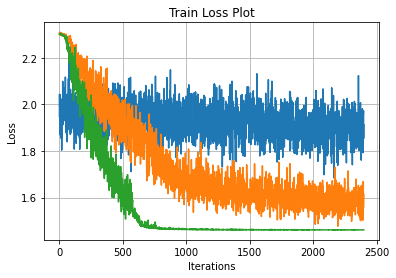

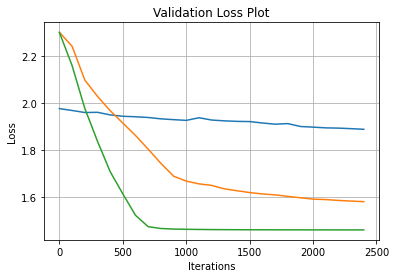

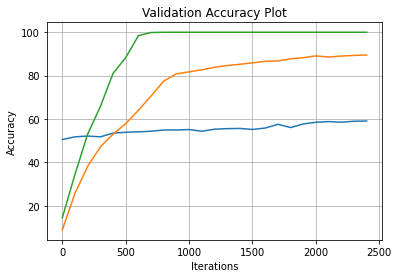

In [151]:
num_iters = len(losses)

plt.figure()
plt.plot(np.arange(num_iters), l_list[0],label="Hidden state 2")
plt.plot(np.arange(num_iters), l_list[1],label="Hidden state 5")
plt.plot(np.arange(num_iters), l_list[2],label="Hidden state 10")
plt.grid()
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Train Loss Plot')
plt.show()

plt.figure()
plt.plot(list(np.arange(1, num_iters-1, interval)) + [num_iters], lt_list[0],label="Hidden state 2")
plt.plot(list(np.arange(1, num_iters-1, interval)) + [num_iters], lt_list[1],label="Hidden state 5")
plt.plot(list(np.arange(1, num_iters-1, interval)) + [num_iters], lt_list[2],label="Hidden state 10")
plt.grid()
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Validation Loss Plot')
plt.show()

plt.figure()
plt.plot(list(np.arange(1, num_iters-1, interval)) + [num_iters], at_list[0])
plt.plot(list(np.arange(1, num_iters-1, interval)) + [num_iters], at_list[1])
plt.plot(list(np.arange(1, num_iters-1, interval)) + [num_iters], at_list[2])
plt.grid()
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy Plot')
plt.show()


In [152]:
# Testing the best model and printing the truth and model generated outputs
num_examples = 2
with torch.no_grad():
    model = models[-1]
    for length in range(3, 11):
        print(f'\nLength {length}:')
        for j in range(num_examples):
            input_ = torch.zeros(size=(2, length, 10))
            for k in range(length):
                number = np.random.randint(low=0, high=10)
                if k==length-1:
                    print(number, end='')
                else:
                    print(f'{number}, ', end='')
                input_[0, k, number] = 1
                if k==position:
                    truth = number
            
            output = model(input_)
            print(f'\tTruth: {truth}, Pred: {output["preds"][0]}')


Length 3:
4, 8, 1	Truth: 8, Pred: 8
0, 2, 1	Truth: 2, Pred: 2

Length 4:
8, 1, 7, 8	Truth: 1, Pred: 1
5, 5, 3, 7	Truth: 5, Pred: 5

Length 5:
8, 2, 3, 3, 4	Truth: 2, Pred: 2
9, 1, 1, 1, 4	Truth: 1, Pred: 1

Length 6:
0, 1, 5, 4, 1, 7	Truth: 1, Pred: 1
1, 8, 9, 7, 1, 1	Truth: 8, Pred: 8

Length 7:
9, 2, 8, 6, 5, 7, 5	Truth: 2, Pred: 2
2, 7, 4, 5, 6, 4, 7	Truth: 7, Pred: 7

Length 8:
5, 9, 1, 7, 0, 2, 8, 3	Truth: 9, Pred: 9
4, 7, 6, 1, 6, 4, 7, 6	Truth: 7, Pred: 7

Length 9:
3, 3, 7, 1, 3, 2, 3, 2, 5	Truth: 3, Pred: 3
9, 1, 3, 0, 9, 9, 5, 5, 7	Truth: 1, Pred: 1

Length 10:
0, 7, 2, 4, 4, 5, 1, 2, 1, 3	Truth: 7, Pred: 7
5, 2, 2, 0, 2, 7, 4, 1, 1, 2	Truth: 2, Pred: 2


# <h1><center><font color = Green> 3. Adding two binary strings</center></h1>


**Dataset Preparation** 


In [153]:
elements_in_batch = 100
num_batches = 500
length = 5
input_list = []
output_list = []

for i in range(num_batches):
    inptemp = torch.zeros(size=(elements_in_batch, length+1, 2))
    outtemp = torch.zeros(size=(elements_in_batch, length+1))
    for j in range(elements_in_batch):
        carry = 0
        for k in range(length):
            temp = torch.randint(low=0, high=2, size=(2,))
            inptemp[j,k,:] = temp
            total = torch.sum(temp).item() + carry
            if total==0:
                carry=0; outtemp[j,k] = 0
            elif total==1:
                carry=0; outtemp[j,k] = 1
            elif total==2:
                carry=1; outtemp[j,k] = 0
            else:
                carry=1; outtemp[j,k] = 1
        outtemp[j,length] = carry
    
    input_list.append(inptemp)
    output_list.append(outtemp)

# Splitting batches for training and testing
trainB = (4*num_batches)//5
train_data = list(zip(input_list[:trainB], output_list[:trainB]))
test_data = list(zip(input_list[trainB:], output_list[trainB:]))

loaders = {
    'train': train_data,
    'test': test_data
}

In [154]:
def train_loop_mod2(loaders, model, loss_fn, optimizer, interval=75):

    dataloader = loaders['train']
    size = len(dataloader)*len(dataloader[0][0])
    losses = []
    losses_test = []
    acc_test = []


    for batch, iter in enumerate(dataloader):
        # Unpacking
        X, y = iter
        
        # Compute prediction and loss
        temp = model(X)
        loss = loss_fn(input=temp['out'], target=y)
        losses.append(loss.item())

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % interval == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"Loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            temp1 = test_loop_mod2(loaders, model, loss_fn)
            losses_test.append(temp1['loss'])
            acc_test.append(temp1['acc'])
        
    return {
        'losses': losses,
        'losses_test': losses_test,
        'acc_test': acc_test
    }



In [155]:
def test_loop_mod2(loaders, model, loss_fn):

    dataloader = loaders['test']
    size = len(dataloader)*dataloader[0][0].shape[0]*dataloader[0][0].shape[1]
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for iter in dataloader:
            # Unpacking
            X, y = iter
            temp = model(X)
            test_loss += loss_fn(input=temp['out'], target=y).item()
            correct += (temp['preds'] == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Metrics: \nAccuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

    return {
        'loss': test_loss,
        'acc': 100*correct
    }

In [156]:
class binLSTM(nn.Module):
    def __init__(self, n_neurons=8, num_layers=1, n_inputs=2, n_outputs=1):
        super(binLSTM, self).__init__()
        
        self.n_neurons = n_neurons
        self.num_layers = num_layers
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.lstm = nn.LSTM(
            input_size=self.n_inputs,
            hidden_size=self.n_neurons,
            num_layers=self.num_layers,
            batch_first=True
        )
        self.FC = nn.Linear(self.n_neurons, self.n_outputs)

    def forward(self, X):
        states, _ = self.lstm(X)
        fcout = self.FC(states)
        out = nn.Sigmoid()(torch.squeeze(fcout))
        preds = torch.round(out)

        return {
			'in': X,
			'out': out,
			'preds': preds,
            'fcout': fcout,
			'states':states
		}

**BCE**

In [157]:
sizes = [2,5,10]
models = [binLSTM(n_neurons=n, num_layers=1, n_inputs=2, n_outputs=1) for n in sizes]
l_list = []
lt_list = []
at_list = []

In [158]:
# Cross Entropy Loss
loss_fn = nn.BCELoss()
# Number of Epochs
num_epochs = 5

In [161]:
for ind, model in enumerate(models):
    print('\n&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&\n')
    print(f'CONFIGURATION: hidden_size = {sizes[ind]}')

    # Adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)
    
    # Measuring time taken for the training process
    losses = []
    losses_test = []
    acc_test = []
    interval = 50
    start = time.time()
    for i in range(num_epochs):
        print(f"Epoch {i+1}\n-------------------------------")
        
        # Training the network for this epoch
        temp = train_loop_mod2(loaders, model, loss_fn, optimizer, interval)
        losses += temp['losses']
        losses_test += temp['losses_test']
        acc_test += temp['acc_test']

    # Testing on the test set
    print('\n-----------------------------------------')
    print('Performance on the Test set...')
    temp = test_loop_mod2(loaders, model, loss_fn)
    losses_test.append(temp['loss'])
    acc_test.append(temp['acc'])

    l_list.append(losses)
    lt_list.append(losses_test)
    at_list.append(acc_test)

    end = time.time()
    print('Time taken for the training: {0:.5f} seconds'.format(end-start))
    print('-----------------------------------------')




&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&

CONFIGURATION: hidden_size = 2
Epoch 1
-------------------------------
Loss: 0.389143  [    0/40000]
Test Metrics: 
Accuracy: 72.7%, Avg loss: 0.411981 

Loss: 0.412706  [ 5000/40000]
Test Metrics: 
Accuracy: 78.0%, Avg loss: 0.404527 

Loss: 0.379682  [10000/40000]
Test Metrics: 
Accuracy: 79.6%, Avg loss: 0.398794 

Loss: 0.386592  [15000/40000]
Test Metrics: 
Accuracy: 79.7%, Avg loss: 0.393577 

Loss: 0.378897  [20000/40000]
Test Metrics: 
Accuracy: 80.2%, Avg loss: 0.388981 

Loss: 0.381529  [25000/40000]
Test Metrics: 
Accuracy: 80.6%, Avg loss: 0.384855 

Loss: 0.400022  [30000/40000]
Test Metrics: 
Accuracy: 80.5%, Avg loss: 0.381528 

Loss: 0.392839  [35000/40000]
Test Metrics: 
Accuracy: 80.8%, Avg loss: 0.378317 

Epoch 2
-------------------------------
Loss: 0.353107  [    0/40000]
Test Metrics: 
Accuracy: 80.6%, Avg loss: 0.374954 

Loss: 0.377055  [ 5000/40000]
Test Metrics: 
Accuracy: 80.6%, Avg loss: 0.372335 

Loss

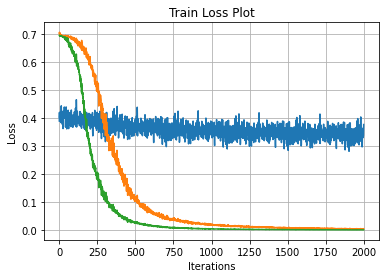

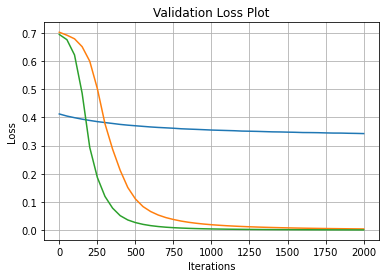

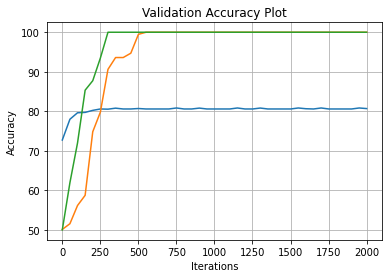

In [162]:
num_iters = len(losses)

plt.figure()
plt.plot(np.arange(num_iters), l_list[0],label="Hidden state 2")
plt.plot(np.arange(num_iters), l_list[1],label="Hidden state 5")
plt.plot(np.arange(num_iters), l_list[2],label="Hidden state 10")
plt.grid()
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Train Loss Plot')
plt.show()

plt.figure()
plt.plot(list(np.arange(1, num_iters-1, interval)) + [num_iters], lt_list[0],label="Hidden state 2")
plt.plot(list(np.arange(1, num_iters-1, interval)) + [num_iters], lt_list[1],label="Hidden state 5")
plt.plot(list(np.arange(1, num_iters-1, interval)) + [num_iters], lt_list[2],label="Hidden state 10")
plt.grid()
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Validation Loss Plot')
plt.show()

plt.figure()
plt.plot(list(np.arange(1, num_iters-1, interval)) + [num_iters], at_list[0])
plt.plot(list(np.arange(1, num_iters-1, interval)) + [num_iters], at_list[1])
plt.plot(list(np.arange(1, num_iters-1, interval)) + [num_iters], at_list[2])
plt.grid()
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy Plot')
plt.show()


**MSE**

In [163]:
sizes = [2,5,10]
models2 = [binLSTM(n_neurons=n, num_layers=1, n_inputs=2, n_outputs=1) for n in sizes]
l_list2 = []
lt_list2 = []
at_list2 = []
# Cross Entropy Loss
loss_fn = nn.MSELoss()
# Number of Epochs
num_epochs = 5

In [165]:
for ind, model in enumerate(models2):
    print('\n&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&\n')
    print(f'CONFIGURATION: hidden_size = {sizes[ind]}')

    # Adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)
    
    # Measuring time taken for the training process
    losses = []
    losses_test = []
    acc_test = []
    interval = 50
    start = time.time()
    for i in range(num_epochs):
        print(f"Epoch {i+1}\n-------------------------------")
        
        # Training the network for this epoch
        temp = train_loop_mod2(loaders, model, loss_fn, optimizer, interval)
        losses += temp['losses']
        losses_test += temp['losses_test']
        acc_test += temp['acc_test']

    # Testing on the test set
    print('\n-----------------------------------------')
    print('Performance on the Test set...')
    temp = test_loop_mod2(loaders, model, loss_fn)
    losses_test.append(temp['loss'])
    acc_test.append(temp['acc'])

    l_list2.append(losses)
    lt_list2.append(losses_test)
    at_list2.append(acc_test)

    end = time.time()
    print('Time taken for the training: {0:.5f} seconds'.format(end-start))
    print('-----------------------------------------')


&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&

CONFIGURATION: hidden_size = 2
Epoch 1
-------------------------------
Loss: 0.266020  [    0/40000]
Test Metrics: 
Accuracy: 50.1%, Avg loss: 0.266309 

Loss: 0.250714  [ 5000/40000]
Test Metrics: 
Accuracy: 50.1%, Avg loss: 0.251777 

Loss: 0.249586  [10000/40000]
Test Metrics: 
Accuracy: 50.0%, Avg loss: 0.250154 

Loss: 0.251065  [15000/40000]
Test Metrics: 
Accuracy: 48.9%, Avg loss: 0.249930 

Loss: 0.248335  [20000/40000]
Test Metrics: 
Accuracy: 53.3%, Avg loss: 0.249091 

Loss: 0.246741  [25000/40000]
Test Metrics: 
Accuracy: 59.6%, Avg loss: 0.245865 

Loss: 0.242209  [30000/40000]
Test Metrics: 
Accuracy: 59.2%, Avg loss: 0.235875 

Loss: 0.229203  [35000/40000]
Test Metrics: 
Accuracy: 63.4%, Avg loss: 0.221583 

Epoch 2
-------------------------------
Loss: 0.208929  [    0/40000]
Test Metrics: 
Accuracy: 64.7%, Avg loss: 0.204320 

Loss: 0.190839  [ 5000/40000]
Test Metrics: 
Accuracy: 66.8%, Avg loss: 0.191061 

Loss

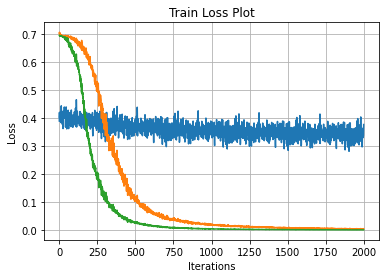

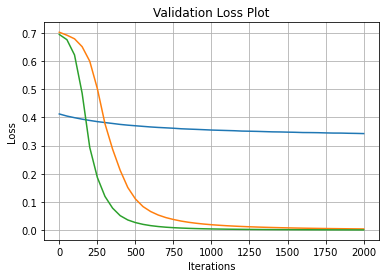

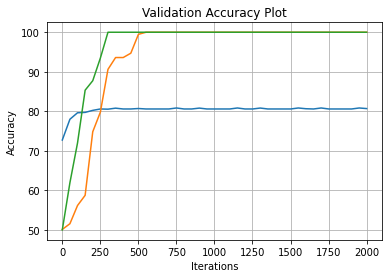

In [166]:
num_iters = len(losses)

plt.figure()
plt.plot(np.arange(num_iters), l_list[0],label="Hidden state 2")
plt.plot(np.arange(num_iters), l_list[1],label="Hidden state 5")
plt.plot(np.arange(num_iters), l_list[2],label="Hidden state 10")
plt.grid()
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Train Loss Plot')
plt.show()

plt.figure()
plt.plot(list(np.arange(1, num_iters-1, interval)) + [num_iters], lt_list[0],label="Hidden state 2")
plt.plot(list(np.arange(1, num_iters-1, interval)) + [num_iters], lt_list[1],label="Hidden state 5")
plt.plot(list(np.arange(1, num_iters-1, interval)) + [num_iters], lt_list[2],label="Hidden state 10")
plt.grid()
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Validation Loss Plot')
plt.show()

plt.figure()
plt.plot(list(np.arange(1, num_iters-1, interval)) + [num_iters], at_list[0])
plt.plot(list(np.arange(1, num_iters-1, interval)) + [num_iters], at_list[1])
plt.plot(list(np.arange(1, num_iters-1, interval)) + [num_iters], at_list[2])
plt.grid()
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy Plot')
plt.show()

 
**Testing on various length inputs**

In [167]:
elements_in_batch = 100
nums_limit = 20
input_list = []
output_list = []

for length in range(1,nums_limit+1):
    inptemp = torch.zeros(size=(elements_in_batch, length+1, 2))
    outtemp = torch.zeros(size=(elements_in_batch, length+1))
    for j in range(elements_in_batch):
        carry = 0
        for k in range(length):
            temp = torch.randint(low=0, high=2, size=(2,))
            inptemp[j,k,:] = temp
            total = torch.sum(temp).item() + carry
            if total==0:
                carry=0; outtemp[j,k] = 0
            elif total==1:
                carry=0; outtemp[j,k] = 1
            elif total==2:
                carry=1; outtemp[j,k] = 0
            else:
                carry=1; outtemp[j,k] = 1
        outtemp[j,length] = carry
    
    input_list.append(inptemp)
    output_list.append(outtemp)

# Splitting batches for training and testing
testing_set = list(zip(input_list, output_list))

In [168]:
acc_vals = np.zeros((nums_limit,6))
mods = models + models2

with torch.no_grad():
    for iter in testing_set:
        (x,y) = iter
        for i, model in enumerate(mods):
            # Unpacking
            temp = model(x)
            correct = (temp['preds'] == y).type(torch.float).sum().item()
            acc_vals[y.shape[1]-2, i] = correct/(y.shape[1]*elements_in_batch)

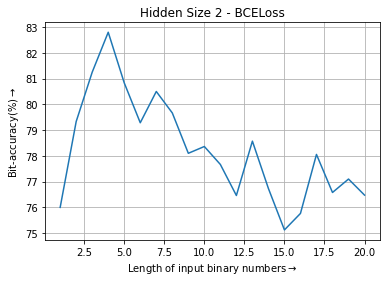

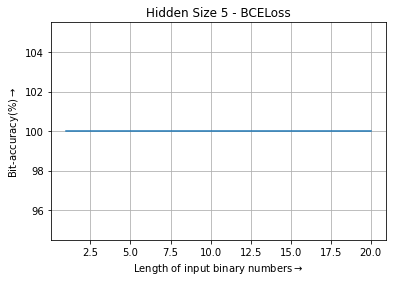

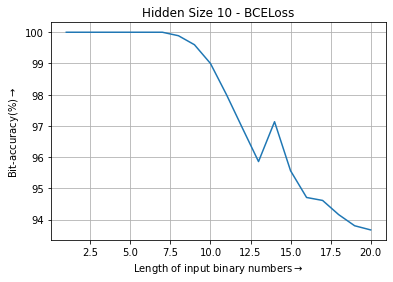

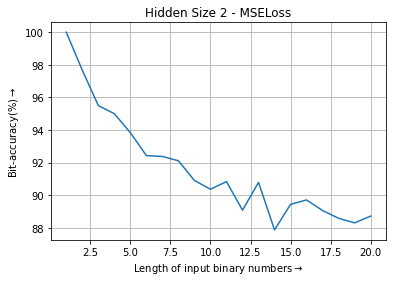

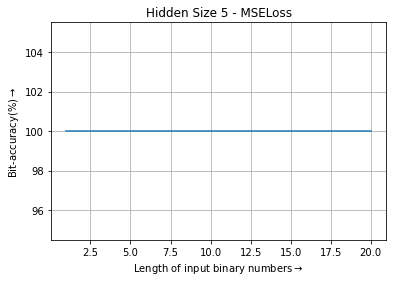

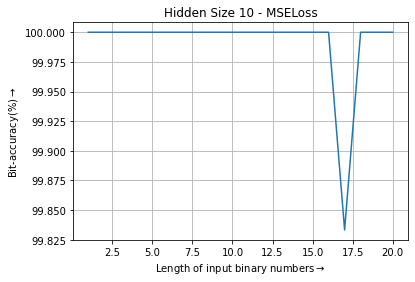

In [169]:
plt.figure()
plt.plot(list(range(1,nums_limit+1)), 100*acc_vals[:,0])
plt.grid()
plt.xlabel(r'Length of input binary numbers$\rightarrow$')
plt.ylabel(r'Bit-accuracy(%)$\rightarrow$')
plt.title('Hidden Size 2 - BCELoss')
plt.show()

plt.figure()
plt.plot(list(range(1,nums_limit+1)), 100*acc_vals[:,1])
plt.grid()
plt.xlabel(r'Length of input binary numbers$\rightarrow$')
plt.ylabel(r'Bit-accuracy(%)$\rightarrow$')
plt.title('Hidden Size 5 - BCELoss')
plt.show()

plt.figure()
plt.plot(list(range(1,nums_limit+1)), 100*acc_vals[:,2])
plt.grid()
plt.xlabel(r'Length of input binary numbers$\rightarrow$')
plt.ylabel(r'Bit-accuracy(%)$\rightarrow$')
plt.title('Hidden Size 10 - BCELoss')
plt.show()

plt.figure()
plt.plot(list(range(1,nums_limit+1)), 100*acc_vals[:,3])
plt.grid()
plt.xlabel(r'Length of input binary numbers$\rightarrow$')
plt.ylabel(r'Bit-accuracy(%)$\rightarrow$')
plt.title('Hidden Size 2 - MSELoss')
plt.show()

plt.figure()
plt.plot(list(range(1,nums_limit+1)), 100*acc_vals[:,4])
plt.grid()
plt.xlabel(r'Length of input binary numbers$\rightarrow$')
plt.ylabel(r'Bit-accuracy(%)$\rightarrow$')
plt.title('Hidden Size 5 - MSELoss')
plt.show()

plt.figure()
plt.plot(list(range(1,nums_limit+1)), 100*acc_vals[:,5])
plt.grid()
plt.xlabel(r'Length of input binary numbers$\rightarrow$')
plt.ylabel(r'Bit-accuracy(%)$\rightarrow$')
plt.title('Hidden Size 10 - MSELoss')
plt.show()